In [1]:
%env OMP_NUM_THREADS=1

import os, sys
if os.path.basename(os.getcwd()) != 'runlmc':
    os.chdir('..')
sys.path.append('benchmarks/benchlib')
import numpy as np

from runlmc.models.interpolated_llgp import InterpolatedLLGP
from runlmc.lmc.functional_kernel import FunctionalKernel
from runlmc.kern.rbf import RBF



%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)

from runlmc.models.optimization import AdaDelta

env: OMP_NUM_THREADS=1


In [5]:
import pandas as pd
nout = 2
df = pd.read_csv ('gpr-test.csv')
df['date-obj']=pd.to_datetime(df['timestamp'])
#plt.plot(df['date-obj'], df['location-long'], label='Longitude')
first_date = df['date-obj'].iloc[0]
df["delta"] = df['date-obj']-first_date
df["delta"] = df["delta"].dt.total_seconds().div(60).astype(int)
df["delta"] = df["delta"] /1000
df2 = df.iloc[0:1000:2]
df2.index
test = df.loc[~df.index.isin(df2.index)][0:500]
#print(len(test), test)

Xs_train = df2['delta'].to_numpy().reshape(-1,1)
ys_train1 = df2['location-long'].to_numpy().reshape(-1, 1)
ys_train2 = df2['location-lat'].to_numpy().reshape(-1, 1)

y_train1_mean = ys_train1.mean(axis = 0)
y_train2_mean = ys_train2.mean(axis = 0)

#print(y_train_mean)
ys_train1 = ys_train1 - y_train1_mean
ys_train2 = ys_train2- y_train2_mean

#print(ys_train)

Xs_test  = test['delta'].to_numpy().reshape(-1,1)
ys_test1  = test['location-long'].to_numpy().reshape(-1,1)
ys_test2  = test['location-lat'].to_numpy().reshape(-1,1)

#y_test_mean = ys_test.mean(axis = 0)
ys_test1 = ys_test1 - y_train1_mean
ys_test2 = ys_test2 - y_train2_mean


xss = Xs_train.reshape(1,500)
yss1 = ys_train1.reshape(1,500)
yss2 = ys_train2.reshape(1,500)
yss = [yss1[0], yss2[0]]
xss = [xss[0], xss[0]]

print(yss)
print(xss)

[array([ 0.00140988,  0.00773988,  0.02603988,  0.03118988,  0.02682988,
        0.01872988,  0.02368988,  0.02704988,  0.03241988,  0.03988988,
        0.04507988,  0.05267988,  0.03333988,  0.02990988,  0.02941988,
        0.02909988,  0.03232988,  0.03571988,  0.06815988,  0.05259988,
        0.04027988,  0.02819988,  0.02465988,  0.02272988,  0.02051988,
        0.02384988,  0.01913988,  0.01803988,  0.01777988,  0.01785988,
        0.01784988,  0.01697988,  0.01856988,  0.02042988,  0.01857988,
        0.02488988,  0.01872988,  0.02025988,  0.02316988,  0.02548988,
        0.02591988,  0.02855988,  0.02924988,  0.02992988,  0.02867988,
        0.02632988,  0.02006988,  0.02504988,  0.02257988,  0.02582988,
        0.02553988,  0.02562988,  0.02868988,  0.02585988,  0.05297988,
        0.06106988,  0.05329988,  0.02742988,  0.02926988,  0.04932988,
        0.05476988,  0.06521988,  0.06045988,  0.06077988,  0.06208988,
        0.06161988,  0.05910988,  0.05839988,  0.05569988,  0.0

In [3]:
import GPy

rbfs = [GPy.kern.RBF(1) for _ in range(nout)]
# not exactly the same since mine is rank-1 only for now
# This is why we need as many kernels as outputs, because we'd be rank-deficient o/w
k = GPy.util.multioutput.LCM(input_dim=1,num_outputs=nout,kernels_list=rbfs)
xss_reshaped = [xs.reshape(-1, 1) for xs in xss]
yss_reshaped = [ys.reshape(-1, 1) for ys in yss]
m = GPy.models.GPCoregionalizedRegression(
    xss_reshaped, yss_reshaped, kernel=k)
m.optimize()
print(yss_reshaped)
print(m)

[array([[ 0.00140988],
       [ 0.00773988],
       [ 0.02603988],
       [ 0.03118988],
       [ 0.02682988],
       [ 0.01872988],
       [ 0.02368988],
       [ 0.02704988],
       [ 0.03241988],
       [ 0.03988988],
       [ 0.04507988],
       [ 0.05267988],
       [ 0.03333988],
       [ 0.02990988],
       [ 0.02941988],
       [ 0.02909988],
       [ 0.03232988],
       [ 0.03571988],
       [ 0.06815988],
       [ 0.05259988],
       [ 0.04027988],
       [ 0.02819988],
       [ 0.02465988],
       [ 0.02272988],
       [ 0.02051988],
       [ 0.02384988],
       [ 0.01913988],
       [ 0.01803988],
       [ 0.01777988],
       [ 0.01785988],
       [ 0.01784988],
       [ 0.01697988],
       [ 0.01856988],
       [ 0.02042988],
       [ 0.01857988],
       [ 0.02488988],
       [ 0.01872988],
       [ 0.02025988],
       [ 0.02316988],
       [ 0.02548988],
       [ 0.02591988],
       [ 0.02855988],
       [ 0.02924988],
       [ 0.02992988],
       [ 0.02867988],
       [ 

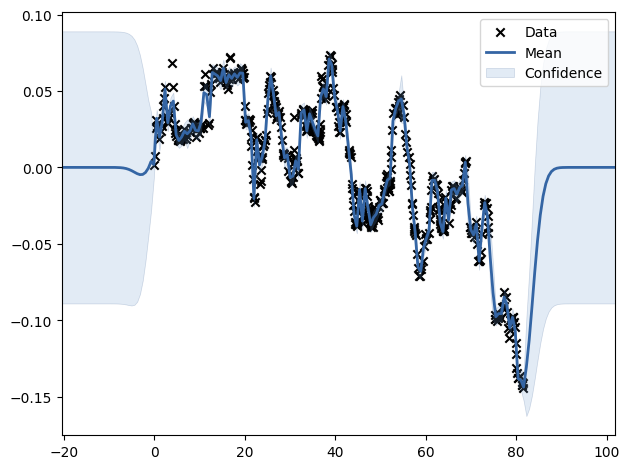

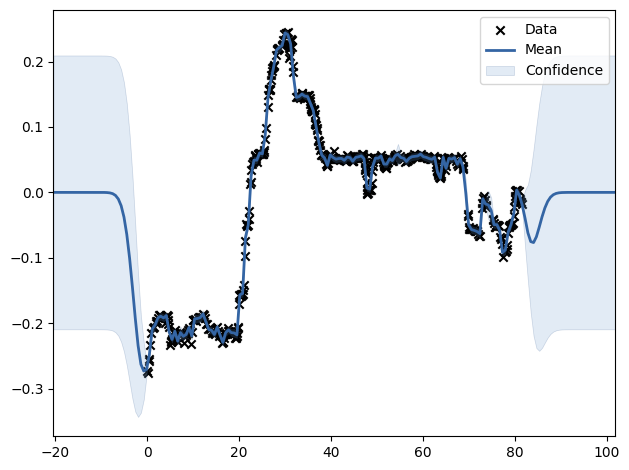

In [4]:
# Plotting code adapted from GPy coregionalization tutorial
# Also 95% confidence
n_per_output = [500, 500]
data_rows = np.add.accumulate(n_per_output)
data_rows = np.insert(data_rows, 0, 0)

for i in range(nout):
    m.plot(
#        plot_limits=(0, 1),
        fixed_inputs=[(1,i)],
        which_data_rows=slice(data_rows[i],data_rows[i + 1]))